In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import os
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

# plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline
    
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)

    
# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

In [2]:
plt.rcParams["figure.figsize"] = [16,9]

In [3]:
def SMAPE (forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

In [5]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [6]:
train = pd.read_csv('C:/Users/PriyaN/Downloads/Demand-Forecasting sample data/Demand-Forecasting/train.csv', parse_dates=['date'], index_col=['date'])
test = pd.read_csv('C:/Users/PriyaN/Downloads/Demand-Forecasting sample data/Demand-Forecasting/test.csv', parse_dates=['date'], index_col=['date'])
train.index = pd.to_datetime(train.index)

In [7]:
train['sales'] = np.log1p(train['sales'])

In [8]:
proph_results = test.reset_index()
proph_results['sales'] = 0


In [9]:
nfl_playoffs = ['2013-01-11','2013-01-12', '2013-01-19','2013-01-26','2013-02-02','2014-01-10', '2014-01-11',
            '2014-01-18', '2014-01-25','2014-02-01','2015-01-16','2015-01-17','2015-01-24','2015-01-31','2015-02-07', '2016-01-14',
            '2016-01-15', '2016-01-22','2016-01-29', '2016-02-05']
major_holidays = ['2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25','2015-01-01', '2015-12-25','2016-01-01', '2016-12-25',
            '2017-01-01', '2017-12-25']

nfl_playoffs = pd.DataFrame({
    'holiday': 'nfl_playoffs',
    'ds': pd.to_datetime(nfl_playoffs),
    'lower_window': 0,
    'upper_window': 1,
})
major_holidays = pd.DataFrame({
    'holiday': 'major_holidays',
    'ds': pd.to_datetime(major_holidays),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat((nfl_playoffs, major_holidays))

In [10]:
for s in proph_results['store'].unique():
    for i in proph_results['item'].unique():
        proph_train = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        proph_train.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        
        m = Prophet(holidays=holidays, holidays_prior_scale=0.5,
            yearly_seasonality=4,  interval_width=0.95,
            changepoint_prior_scale=0.006, daily_seasonality=True)
        m.fit(proph_train[['ds', 'y']])
        future = m.make_future_dataframe(periods=len(test.index.unique()), include_history=False)
        fcst = m.predict(future)
        
        proph_results.loc[(proph_results['store'] == s) & (proph_results['item'] == i), 'sales'] = np.expm1(fcst['yhat']).values

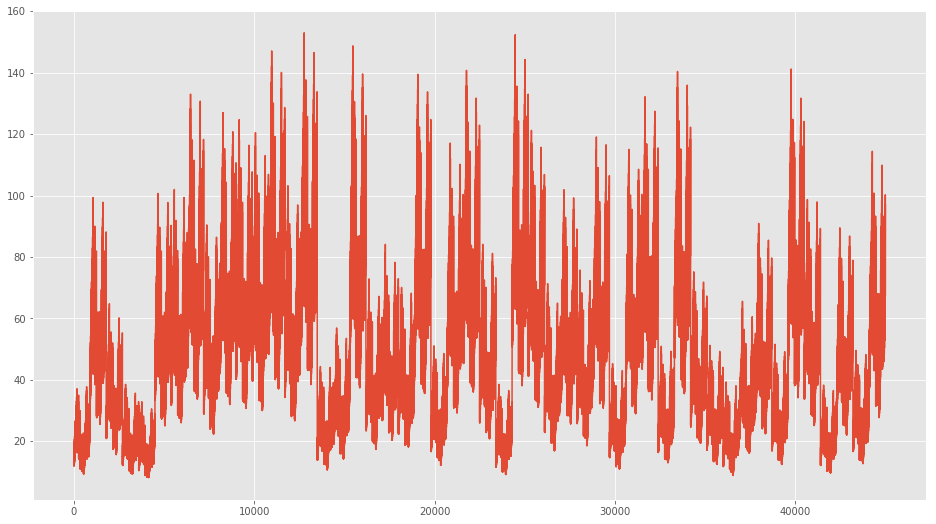

In [11]:
proph_results.drop(['date', 'store', 'item'], axis=1, inplace=True)
plt.plot(proph_results.id,proph_results.sales)

In [12]:
proph_results.to_csv('proph_results.csv', index=False)